In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [28]:
# Configuration
DATA_CSV_PATH = "role_challenge_dataset_ground_truth.csv"  
IMAGE_DIR = "images"                  
IMAGE_SIZE = 256
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
MODEL_SAVE_PATH = "resnet18_landmark_detector.pth"

In [29]:
# Define dataset class
class LandmarkDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        
        # Get landmarks (8 values: ofd_1_x, ofd_1_y, ofd_2_x, ofd_2_y, bpd_1_x, bpd_1_y, bpd_2_x, bpd_2_y)
        landmarks = self.dataframe.iloc[idx, 1:].values.astype('float32')
        
        # Original image dimensions for normalization
        orig_width, orig_height = image.size
        
        if self.transform:
            image = self.transform(image)
            
        # Normalize landmarks to [0, 1] range
        landmarks[0] /= orig_width  # ofd_1_x
        landmarks[1] /= orig_height # ofd_1_y
        landmarks[2] /= orig_width  # ofd_2_x
        landmarks[3] /= orig_height # ofd_2_y
        landmarks[4] /= orig_width  # bpd_1_x
        landmarks[5] /= orig_height # bpd_1_y
        landmarks[6] /= orig_width  # bpd_2_x
        landmarks[7] /= orig_height # bpd_2_y
        
        return image, torch.tensor(landmarks)

In [30]:
# Define the model
class LandmarkResNet(nn.Module):
    def __init__(self, num_landmarks=8):
        super(LandmarkResNet, self).__init__()
        # Use pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)
        
        # Replace the final fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_landmarks)
        
    def forward(self, x):
        return self.base_model(x)

In [31]:
# Define the model
class LandmarkResNet(nn.Module):
    def __init__(self, num_landmarks=8):
        super(LandmarkResNet, self).__init__()
        # Use pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)
        
        # Replace the final fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_landmarks)
        
    def forward(self, x):
        return self.base_model(x)

# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [32]:
# Load and prepare data
def prepare_datasets():
    # Load CSV
    df = pd.read_csv(DATA_CSV_PATH)
    
    # Split data
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = LandmarkDataset(train_df, IMAGE_DIR, data_transforms['train'])
    val_dataset = LandmarkDataset(val_df, IMAGE_DIR, data_transforms['val'])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    return train_loader, val_loader


In [33]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, landmarks in train_loader:
            images = images.to(device)
            landmarks = landmarks.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, landmarks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for images, landmarks in val_loader:
                images = images.to(device)
                landmarks = landmarks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, landmarks)
                
                running_val_loss += loss.item() * images.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')
    
    return train_losses, val_losses


In [34]:
# Visualization function
def visualize_predictions(model, dataloader, num_samples=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (images, landmarks) in enumerate(dataloader):
            images = images.to(device)
            landmarks = landmarks.to(device)
            
            outputs = model(images)
            
            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_samples, 2, images_so_far)
                ax.axis('off')
                
                # Denormalize image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                # Get predicted and ground truth landmarks
                pred_landmarks = outputs.cpu().data[j].numpy()
                true_landmarks = landmarks.cpu().data[j].numpy()
                
                # Convert normalized coordinates back to pixel coordinates
                height, width = img.shape[:2]
                pred_landmarks[0] *= width  # ofd_1_x
                pred_landmarks[1] *= height # ofd_1_y
                pred_landmarks[2] *= width  # ofd_2_x
                pred_landmarks[3] *= height # ofd_2_y
                pred_landmarks[4] *= width  # bpd_1_x
                pred_landmarks[5] *= height # bpd_1_y
                pred_landmarks[6] *= width  # bpd_2_x
                pred_landmarks[7] *= height # bpd_2_y
                
                true_landmarks[0] *= width  # ofd_1_x
                true_landmarks[1] *= height # ofd_1_y
                true_landmarks[2] *= width  # ofd_2_x
                true_landmarks[3] *= height # ofd_2_y
                true_landmarks[4] *= width  # bpd_1_x
                true_landmarks[5] *= height # bpd_1_y
                true_landmarks[6] *= width  # bpd_2_x
                true_landmarks[7] *= height # bpd_2_y
                
                # Plot image
                plt.imshow(img)
                
                # Plot predicted landmarks (red)
                plt.scatter(pred_landmarks[0], pred_landmarks[1], c='r', marker='x', s=100, label='Pred OFD1' if j == 0 else "")
                plt.scatter(pred_landmarks[2], pred_landmarks[3], c='r', marker='x', s=100, label='Pred OFD2' if j == 0 else "")
                plt.scatter(pred_landmarks[4], pred_landmarks[5], c='r', marker='x', s=100, label='Pred BPD1' if j == 0 else "")
                plt.scatter(pred_landmarks[6], pred_landmarks[7], c='r', marker='x', s=100, label='Pred BPD2' if j == 0 else "")
                
                # Plot true landmarks (green)
                plt.scatter(true_landmarks[0], true_landmarks[1], c='g', marker='o', s=100, facecolors='none', label='True OFD1' if j == 0 else "")
                plt.scatter(true_landmarks[2], true_landmarks[3], c='g', marker='o', s=100, facecolors='none', label='True OFD2' if j == 0 else "")
                plt.scatter(true_landmarks[4], true_landmarks[5], c='g', marker='o', s=100, facecolors='none', label='True BPD1' if j == 0 else "")
                plt.scatter(true_landmarks[6], true_landmarks[7], c='g', marker='o', s=100, facecolors='none', label='True BPD2' if j == 0 else "")
                
                if j == 0:
                    plt.legend()
                
                if images_so_far == num_samples * 2:
                    plt.tight_layout()
                    return fig
        
    plt.tight_layout()
    return fig


In [38]:
# Check if the model file exists
if os.path.isfile(MODEL_SAVE_PATH):
    # Load the model
    print("Loading pre-trained model...")
    model = LandmarkResNet().to(device)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Pre-trained model loaded.")
    
    # Prepare data
    print("Preparing datasets...")
    train_loader, val_loader = prepare_datasets()
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Get the loss
    print("Starting validation...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, 2)

else:
    # Prepare data
    print("Preparing datasets...")
    train_loader, val_loader = prepare_datasets()

    # Initialize model
    model = LandmarkResNet().to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train model
    print("Starting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

    # Save model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")


Loading pre-trained model...
Pre-trained model loaded.
Preparing datasets...
Starting validation...
Epoch 1/2, Train Loss: 0.003611, Val Loss: 0.016582
Epoch 2/2, Train Loss: 0.004370, Val Loss: 0.016978


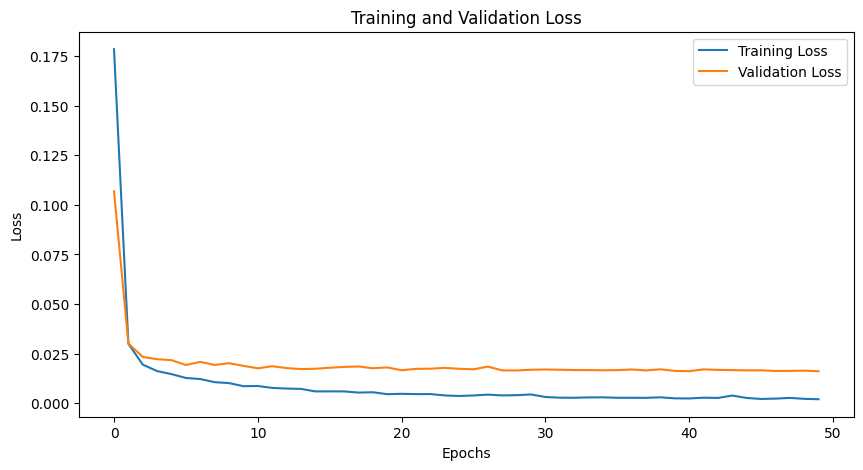

Visualizing predictions...


/tmp/ipykernel_312202/170781295.py:60: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(true_landmarks[0], true_landmarks[1], c='g', marker='o', s=100, facecolors='none', label='True OFD1' if j == 0 else "")
/tmp/ipykernel_312202/170781295.py:61: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(true_landmarks[2], true_landmarks[3], c='g', marker='o', s=100, facecolors='none', label='True OFD2' if j == 0 else "")
/tmp/ipykernel_312202/170781295.py:62: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(true_landmarks[4], true_landmarks[5], c='g', marker='o', s=100, facecolors='none', label='True BPD1' if j == 0 else "")
/tmp/ipyke

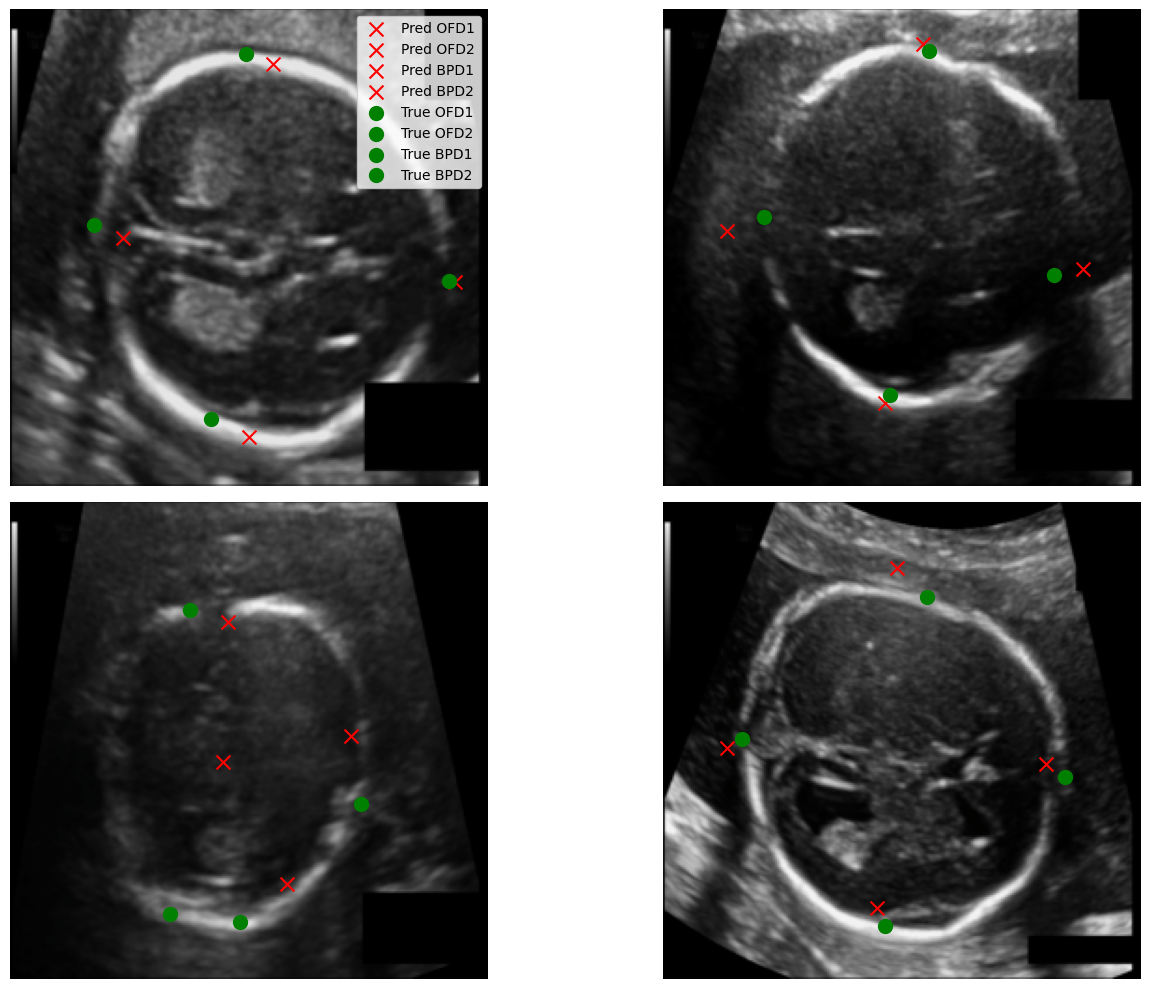

In [37]:

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('training_history.png')
plt.show()

# Visualize predictions
print("Visualizing predictions...")
fig = visualize_predictions(model, val_loader, num_samples=2)
plt.savefig('predictions_visualization.png')
plt.show()
